In [34]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from utils.utils import get_MNIST_dataset, onehot_decode_mnist_labels, show_images, skip_if
from sklearn.model_selection import train_test_split

In [9]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


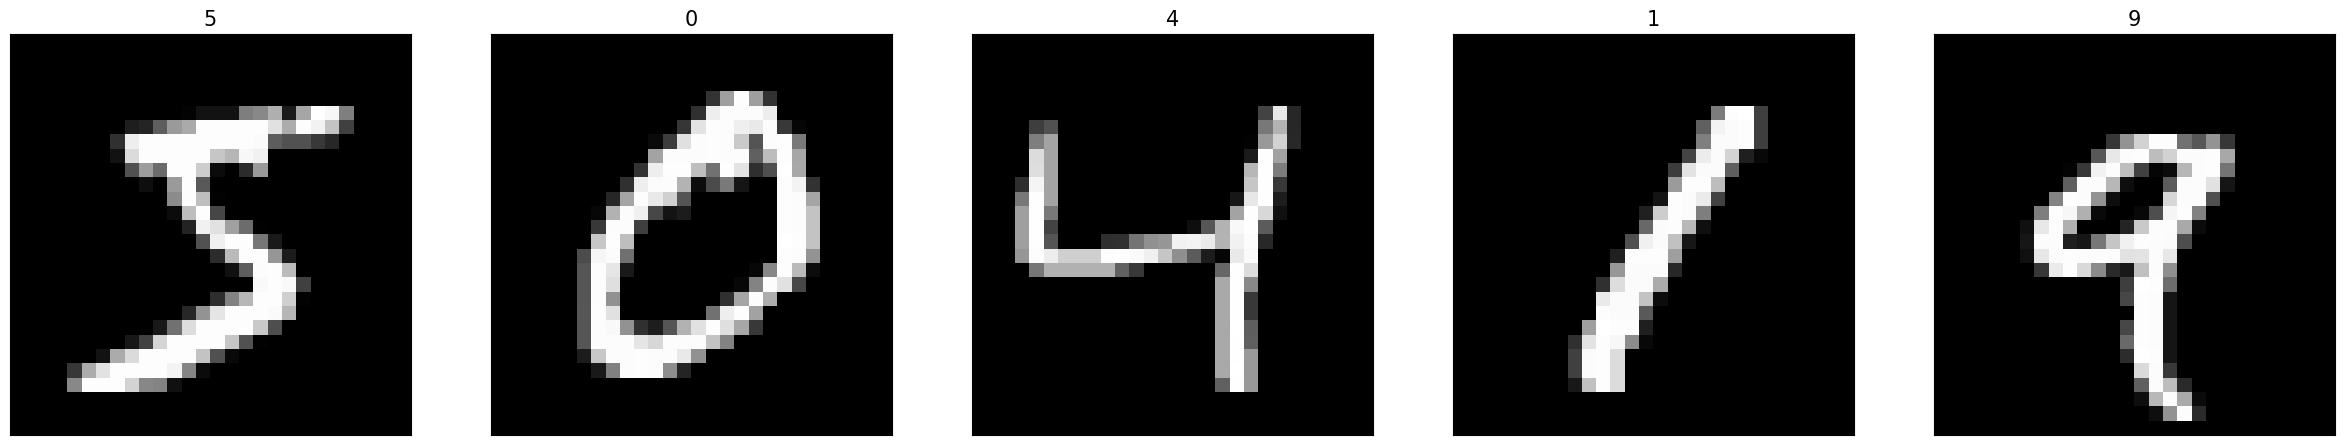

In [14]:
# Load MNIST dataset
X, y = get_MNIST_dataset()
y = onehot_decode_mnist_labels(y)
show_images(X[:5], y[:5])

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X.shape[1], 256),
            nn.Sigmoid(),
            nn.Linear(256, 256),
            nn.Sigmoid(),
            nn.Linear(256, y.shape[1]),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [32]:
def accuracy(model):
    model.eval()  # set model to evaluation mode 
    correct = 0
    total = 0
    with torch.no_grad():  # disable gradient calculation for evaluation 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)  # class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [45]:
def train_model(lr=0.01, num_epochs=10, lambd=1e-4):
    model = NeuralNetwork().to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lambd)
    for _ in range(num_epochs):
        model.train()  # set model to training mode
        for images, labels in train_loader:
            # Move data to device (GPU if available, else CPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()            # reset gradients to zero
            outputs = model(images)          # forward pass: compute predictions
            loss = criterion(outputs, labels)  # compute cross-entropy loss
            loss.backward()                 # backpropagate to compute gradients
            optimizer.step()                # update weights using SGD step 

    return accuracy(model)

In [46]:
learning_rates = np.logspace(-1, 1, 5)
lambdas = np.logspace(-10, -5, 6)

accuracies = np.zeros((len(learning_rates), len(lambdas)))
for i, lr in enumerate(learning_rates):
    for j, lambd in enumerate(lambdas):
        print(f"Training with learning rate: {lr} and lambda: {lambd}")
        acc = train_model(lr=lr, num_epochs=5, lambd=lambd)
        accuracies[i,j] = acc

Training with learning rate: 0.1 and lambda: 1e-10
Training with learning rate: 0.1 and lambda: 1e-09
Training with learning rate: 0.1 and lambda: 1e-08
Training with learning rate: 0.1 and lambda: 1e-07
Training with learning rate: 0.1 and lambda: 1e-06
Training with learning rate: 0.1 and lambda: 1e-05
Training with learning rate: 0.31622776601683794 and lambda: 1e-10
Training with learning rate: 0.31622776601683794 and lambda: 1e-09
Training with learning rate: 0.31622776601683794 and lambda: 1e-08
Training with learning rate: 0.31622776601683794 and lambda: 1e-07
Training with learning rate: 0.31622776601683794 and lambda: 1e-06
Training with learning rate: 0.31622776601683794 and lambda: 1e-05
Training with learning rate: 1.0 and lambda: 1e-10
Training with learning rate: 1.0 and lambda: 1e-09
Training with learning rate: 1.0 and lambda: 1e-08
Training with learning rate: 1.0 and lambda: 1e-07
Training with learning rate: 1.0 and lambda: 1e-06
Training with learning rate: 1.0 and 

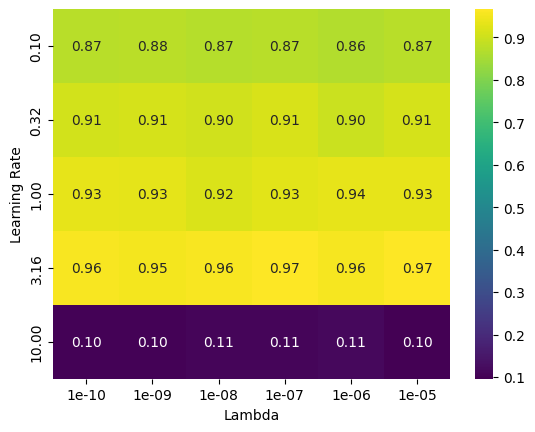

In [47]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Heatmap
sns.heatmap(
    accuracies,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=list(map(lambda x: f"{x:.0e}", lambdas)),
    yticklabels=list(map(lambda x: f"{x:.2f}", learning_rates)),

)
plt.xlabel("Lambda")
plt.ylabel("Learning Rate")
plt.show()